# Mathematical Underpinnings - Lab 7

In [3]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [4]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [5]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [6]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# np.random.seed(123)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))


In [7]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [8]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [9]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.3725369467349484

In [10]:
# 18:56

### c)

In [11]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [16]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [18]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0088 - val_loss: -0.0229
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0349 - val_loss: -0.0423
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0549 - val_loss: -0.0521
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: -0.0681 - val_loss: -0.0573
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0695 - val_loss: -0.0605
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: -0.0846 - val_loss: -0.0629
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0824 - val_loss: -0.0651
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0869 - val_loss: -0.0672
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0857 - val_loss: -0.0695
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0972 - val_loss: -0.0722
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0917 - val_loss: -0.0753
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━

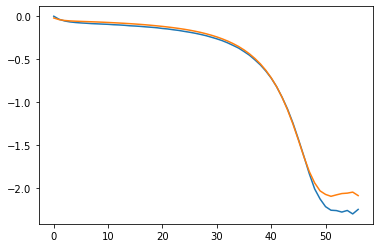

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [20]:
t_x_pred = model.predict(x)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [21]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

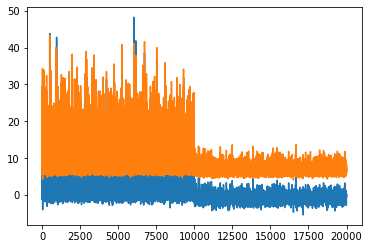

In [22]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

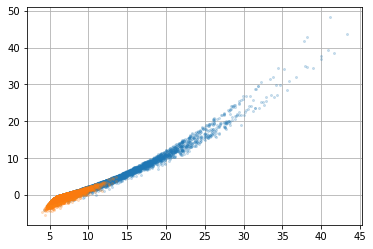

In [23]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

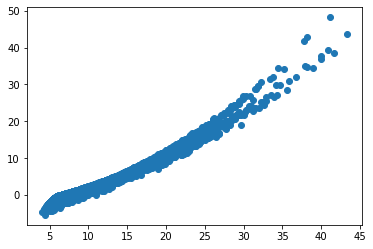

In [24]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [25]:
DV_fun(y, t_x_pred)

2.225474305604955

In [26]:
DV_fun(y, t_x_opt)

2.3725369467349484

In [27]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [28]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [29]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [30]:
DV_fun(y_new, t_x_pred)

2.1321803431376676

In [31]:
DV_fun(y_new, t_x_opt)

2.430707887740891

### f)

In [35]:
def NWJ_loss(y_true, y_pred):
    first_term = tf.math.reduce_mean(y_pred[y_true==1])
    second_term = tf.math.reduce_mean(tf.math.exp(y_pred[y_true==0] - 1))
    return - (first_term - second_term)

In [36]:
def NWJ_fun(y, t):
    return np.sum(t*y)/np.sum(y) - np.sum(np.exp(t-1)*(1-y))/np.sum(1 - y)

In [38]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [40]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1133 - val_loss: 0.0477
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349 - val_loss: -0.0016
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0058 - val_loss: -0.0312
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0323 - val_loss: -0.0501
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0465 - val_loss: -0.0622
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0589 - val_loss: -0.0703
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: -0.0625 - val_loss: -0.0759
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0684 - val_loss: -0.0806
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0760 - val_loss: -0.0842
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0769 - val_loss: -0.0873
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0867 - val_loss: -0.0903
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s

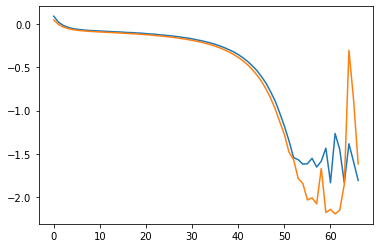

In [41]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [42]:
t_x_pred = model.predict(x)[:,0]


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [43]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

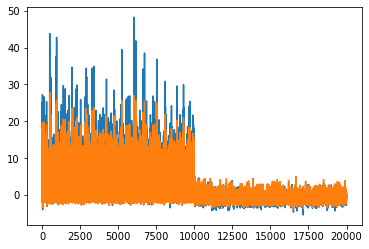

In [44]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

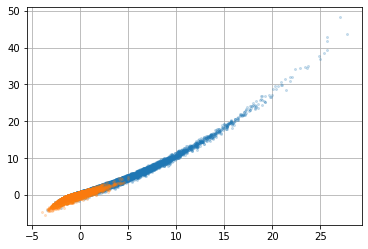

In [45]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

In [46]:
NWJ_fun(y_new, t_x_pred)

1.5834827538907064

In [47]:
NWJ_fun(y_new, t_x_opt)

1.9108108343890102